# Building image classification models and using them on edge devices

Traditionally, training image classification models requires a deep understanding of complex algorithms and programming languages. It is a significant barrier for individuals who are just starting or have limited coding experience.

However, this process of building an Image classification model can be made codeless through the help of [Teachable Machines](https://teachablemachine.withgoogle.com/). Teachable Machines is a user-friendly and intuitive platform developed by Google that allows anyone, regardless of their coding experience, to create custom image classification models with ease.

With Teachable Machines, you can train your own image classifier by simply providing examples of the objects or categories you want to recognize. You can use your webcam or upload images to create your custom dataset. The platform then takes care of the complex algorithms and training process behind the scenes, making it accessible to beginners and experts alike.

In this experiment, we will explore how to create various types of image classification models using Teachable Machines. Afterwards, we will apply these models to make predictions on Edge devices.

This notebook assumes you already have a “lease” available for a device on the CHI@Edge testbed. Then, it will show you how to:

-   launch a “container” on that device
-   attach an IP address to the container, so that you can access it over SSH
-   train and download an image classification model on Teachable machines.
-   transfer files to and from the container
-   use the trained image classification model to do inference on the edge device
-   delete the container

## Launch a container on an edge device

We will start by preparing our environment in this notebook, then launching a container on an edge device using our pre-existing lease.

First, we load some required libraries:

In [ ]:
import chi
from chi import container
from chi import lease
import datetime
import os

We indicate that we’re going to use the CHI@Edge site. We also need to specify the name of the Chameleon “project” that this experiment is part of. The project name will have the format “CHI-XXXXXX”, where the last part is a 6-digit number, and you can find it on your [user dashboard](https://chameleoncloud.org/user/dashboard/).

In the cell below, replace the project ID with your *own* project ID, then run the cell.

In [ ]:
chi.use_site("CHI@Edge")
chi.set("project_name", "CHI-XXXXXX")

Next, we’ll specify the lease ID. This notebook assumes you already have a “lease” for a device on CHI@Edge. To get the ID of this lease,

-   Vist the CHI@Edge [“reservations” page](https://chi.edge.chameleoncloud.org/project/leases/).
-   Click on the lease name.
-   On the following page, look for the value next to the word “Id” in the “Lease” section.

Fill in the lease ID inside the quotation marks in the following cell, then run the cell.

In [ ]:
lease_id ="xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxx"

Now, we are ready to launch a container!

First, we’ll specify the name for our container - we’ll include our username and the experiment name in the container name, so that it will be easy to identify our container in the CHI@Edge web interface.

In [ ]:
username = os.environ.get("USER")
expname = "edge-cpu"
# set a name for the container
# Note that underscore characters _ are not allowed - we replace each _ with a -
container_name = f"{username}-{expname}".replace("_","-")

Then, we can create the container!

In [ ]:
try:
    my_container = container.create_container(
        container_name,
        image="python:3.9-slim",
        reservation_id=lease.get_device_reservation(lease_id),
        interactive=True,
        exposed_ports=[22],
        platform_version=2,
    )
except RuntimeError as ex:
    print(ex)
    print(f"Please stop and/or delete {container_name} and try again")
else:
    print(f"Successfully created container: {container_name}!")

The next cell waits for the container to be active - when it is, it will print some output related to the container state.

In [ ]:
# wait until container is ready to use
container.wait_for_active(my_container.uuid)

Once the container is created, you should be able to see it and monitor its status on the [CHI@Edge web interface](https://chi.edge.chameleoncloud.org/project/container/containers). (If there was any problem while creating the container, you can also delete the container from that interface, in order to be able to try again.)

## Attach an address and access your container over SSH

Just as with a conventional “server” on Chameleon, we can attach an address to our container, then use SSH to access its terminal.

First, we’ll attach an address:

In [ ]:
public_ip = container.associate_floating_ip(my_container.uuid)

Then, we need to install an SSH server on the container - it is not pre-installed on the image we selected. We can use the `container.execute()` function to run commands inside the container, in order to install the SSH server.

In [ ]:
container.execute(my_container.uuid, 'apt update')
container.execute(my_container.uuid, 'apt -y install openssh-server')

There is one more necessary step before we can access the container over SSH - we need to make sure our key is installed on the container. Here, we will upload the key from the Jupyter environment, and make sure it is configured with the appropriate file permissions:

In [ ]:
!mkdir -p tmp_keys
!cp /work/.ssh/id_rsa.pub tmp_keys/authorized_keys

In [ ]:
container.execute(my_container.uuid, 'mkdir -p /root/.ssh')
container.upload(my_container.uuid, "./tmp_keys", "/root/.ssh")
container.execute(my_container.uuid, 'chown root /root/.ssh')
container.execute(my_container.uuid, 'chown root /root/.ssh/authorized_keys')
container.execute(my_container.uuid, 'chmod go-w /root')
container.execute(my_container.uuid, 'chmod 700 /root/.ssh')
container.execute(my_container.uuid, 'chmod 600 /root/.ssh/authorized_keys')

Start the SSH server in the container. The following cell should print “sshd is running”. It it’s not running, it can be an indication that the SSH server was not fully installed; wait a minute or two and then try this cell again:

In [ ]:
container.execute(my_container.uuid, 'service ssh start')
container.execute(my_container.uuid, 'service ssh status')

Now we can open a terminal in the Jupyter interface to access the container over SSH, using the SSH command that is printed by the following cell:

In [ ]:
print("ssh root@%s" % public_ip)

## Train and download an image classification model on Teachable machines

### The following are the steps involved to train an Image classification model on Teachable machine.

-   **Access Teachable Machine**: Visit the Teachable Machine website at https://teachablemachine.withgoogle.com to access the platform , the platform looks similar to this and then click on Get Started.

![](./images/tm_launch.png)

-   **Choose Image Project**: On the Teachable Machine homepage, you’ll see various project choices. Select the “Image Project” option, as we are training an image classification model.

![](./images/project.png)

-   **Setting Up Categories & Add Datasets**: Define the categories or classes you want your model to recognize. For example, if you’re building a model to classify animals, you might create categories like “cat,” “dog,” and “bird.” Assign a label to each category, which will be displayed during the training process. You can either use images stored on your computer or capture images directly using your webcam if you prefer to create a dataset on the fly.

-   **Training the Model**: After uploading your dataset, click the “Train Model” button. Teachable Machine will begin the training process using the images you provided. The platform uses a pre-trained model (Mobilenetv2) and fine-tunes it on your custom dataset.

![](./images/train.png)

-   **Monitoring Training Progress**: During the training process, you can click on Under the hood button and observe the progress of the model’s training. Teachable Machine will display the training loss and accuracy metrics, allowing you to track how well the model is learning to classify the images.

-   **Exporting the Model**: Once you are satisfied with the performance of your model, you can export it in different formats, such as TensorFlow.js, TensorFlow Lite, or a URL. Here in our case we will be using quantized version of Tensorflow lite. Once you click on download my model, it will take some 2-3 minutes to get downloaded and then a zip file would be downloaded which contains a tflite model and a label.txt file that contains the label name.

![](./images/export.png)

-   **Uploading the model on Jupyter hub**: Once you’ve completed the download of the model, the next step is to unzip the downloaded file. After unzipping, you’ll have both the model and label files ready. Now, it’s time to upload these files onto Jupyter Hub. Assuming you’ve already followed the initial instructions and cloned the repository, you’ll find a folder named “image_model” within it. Access this folder, and you’ll see an upload button(Marked in red in the image below). Simply click on it and proceed to upload both the model and label files to Jupyter Hub. This action will make the files readily available for further use and analysis.

![](./images/upload.png)
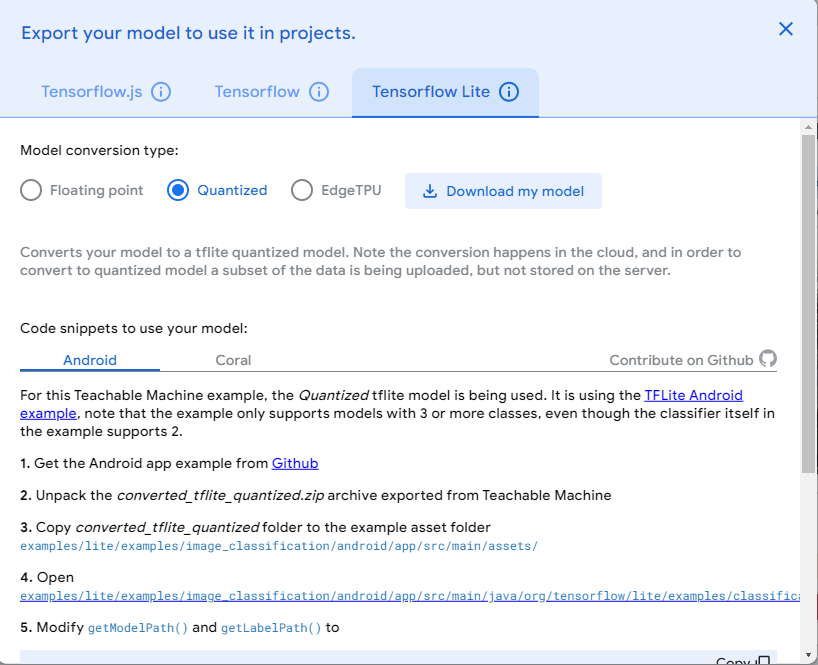
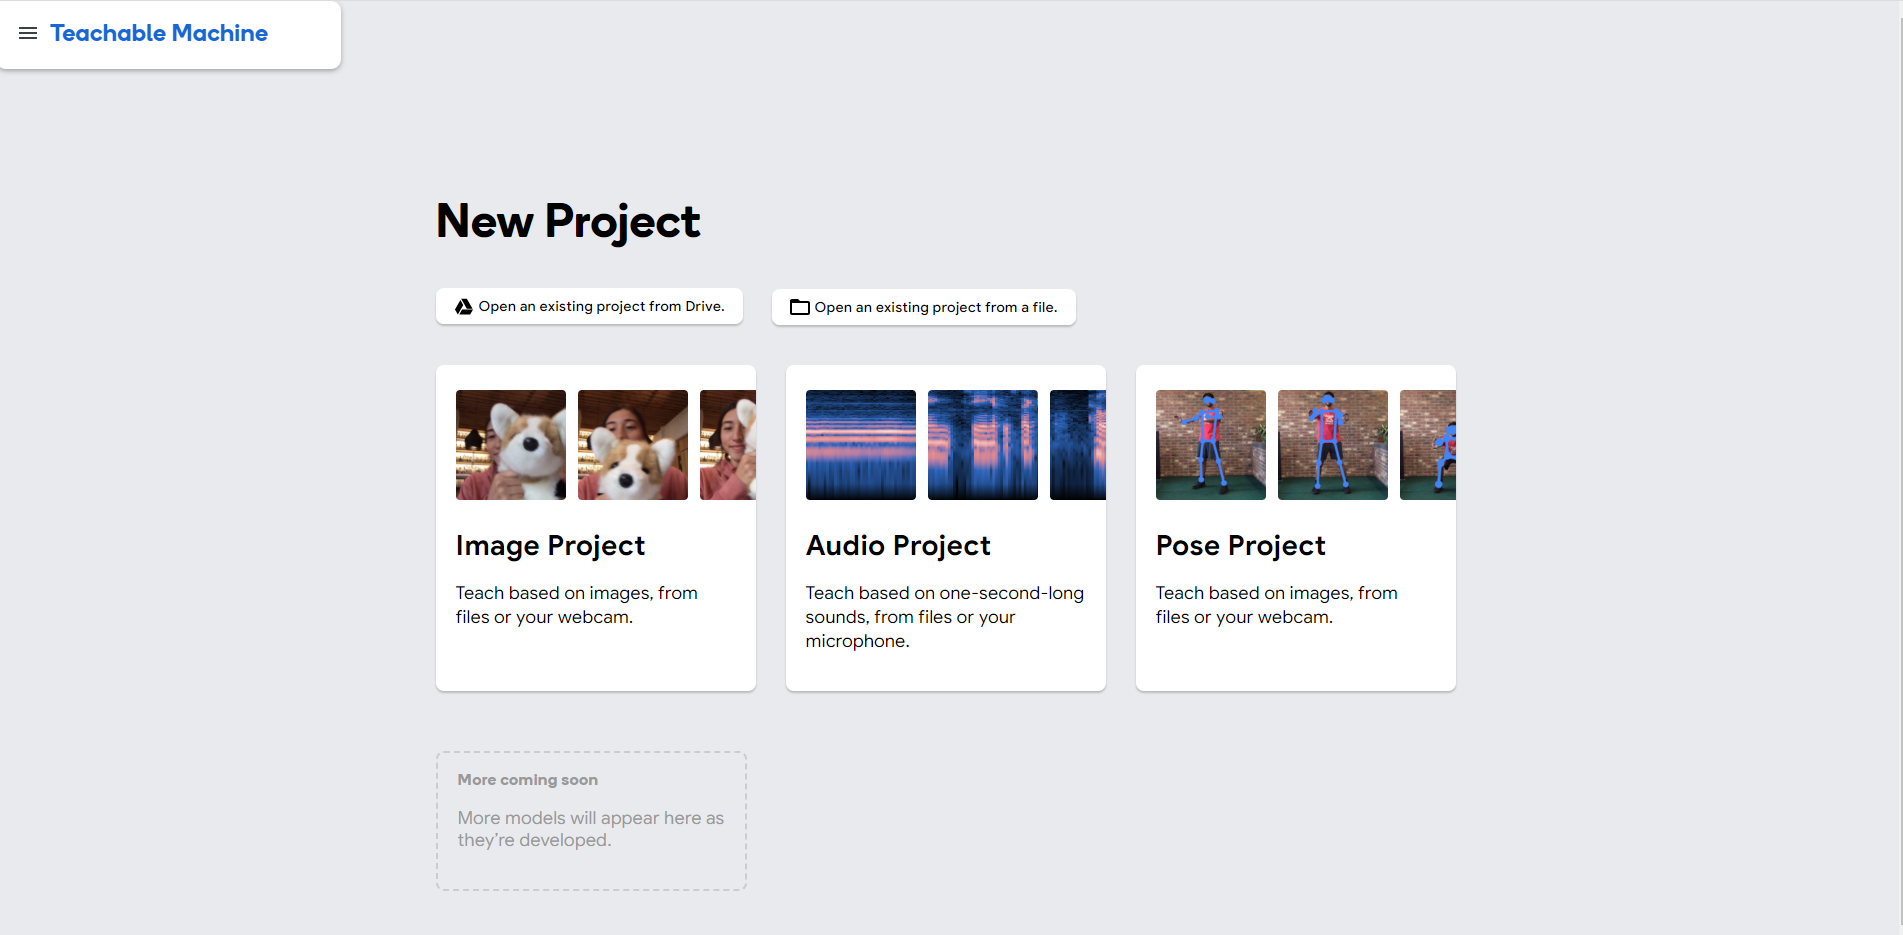
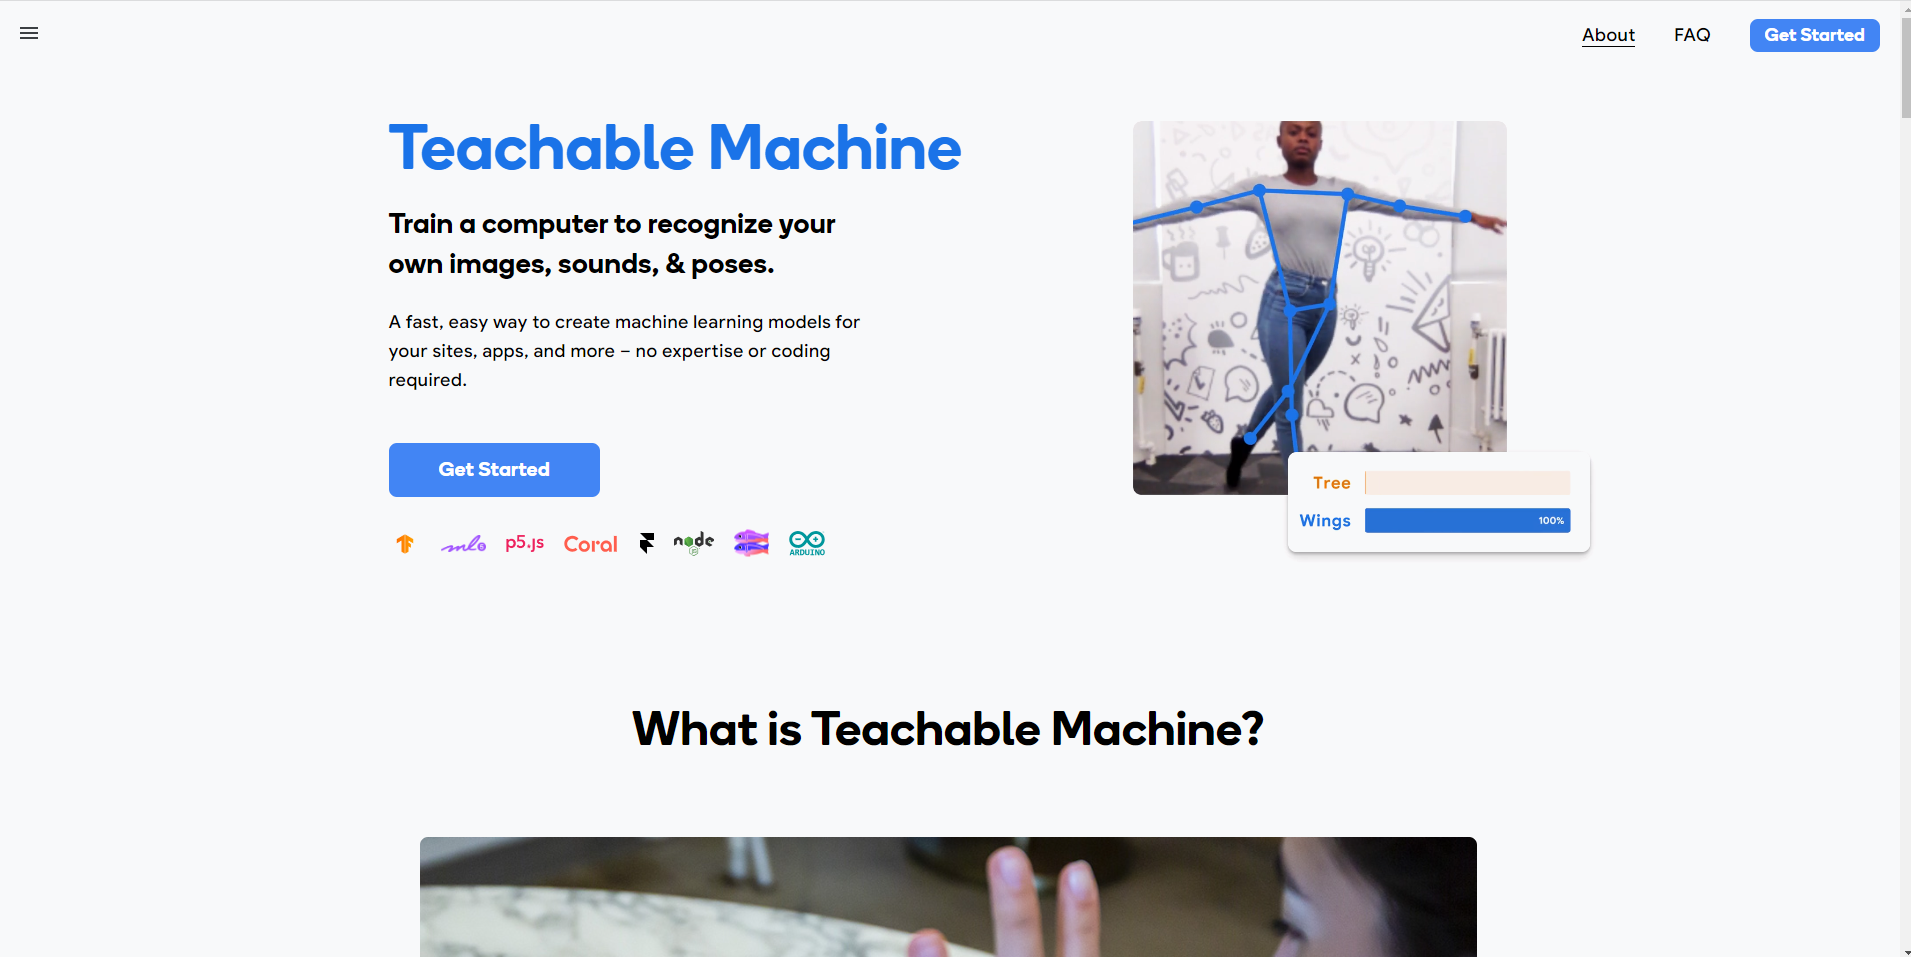
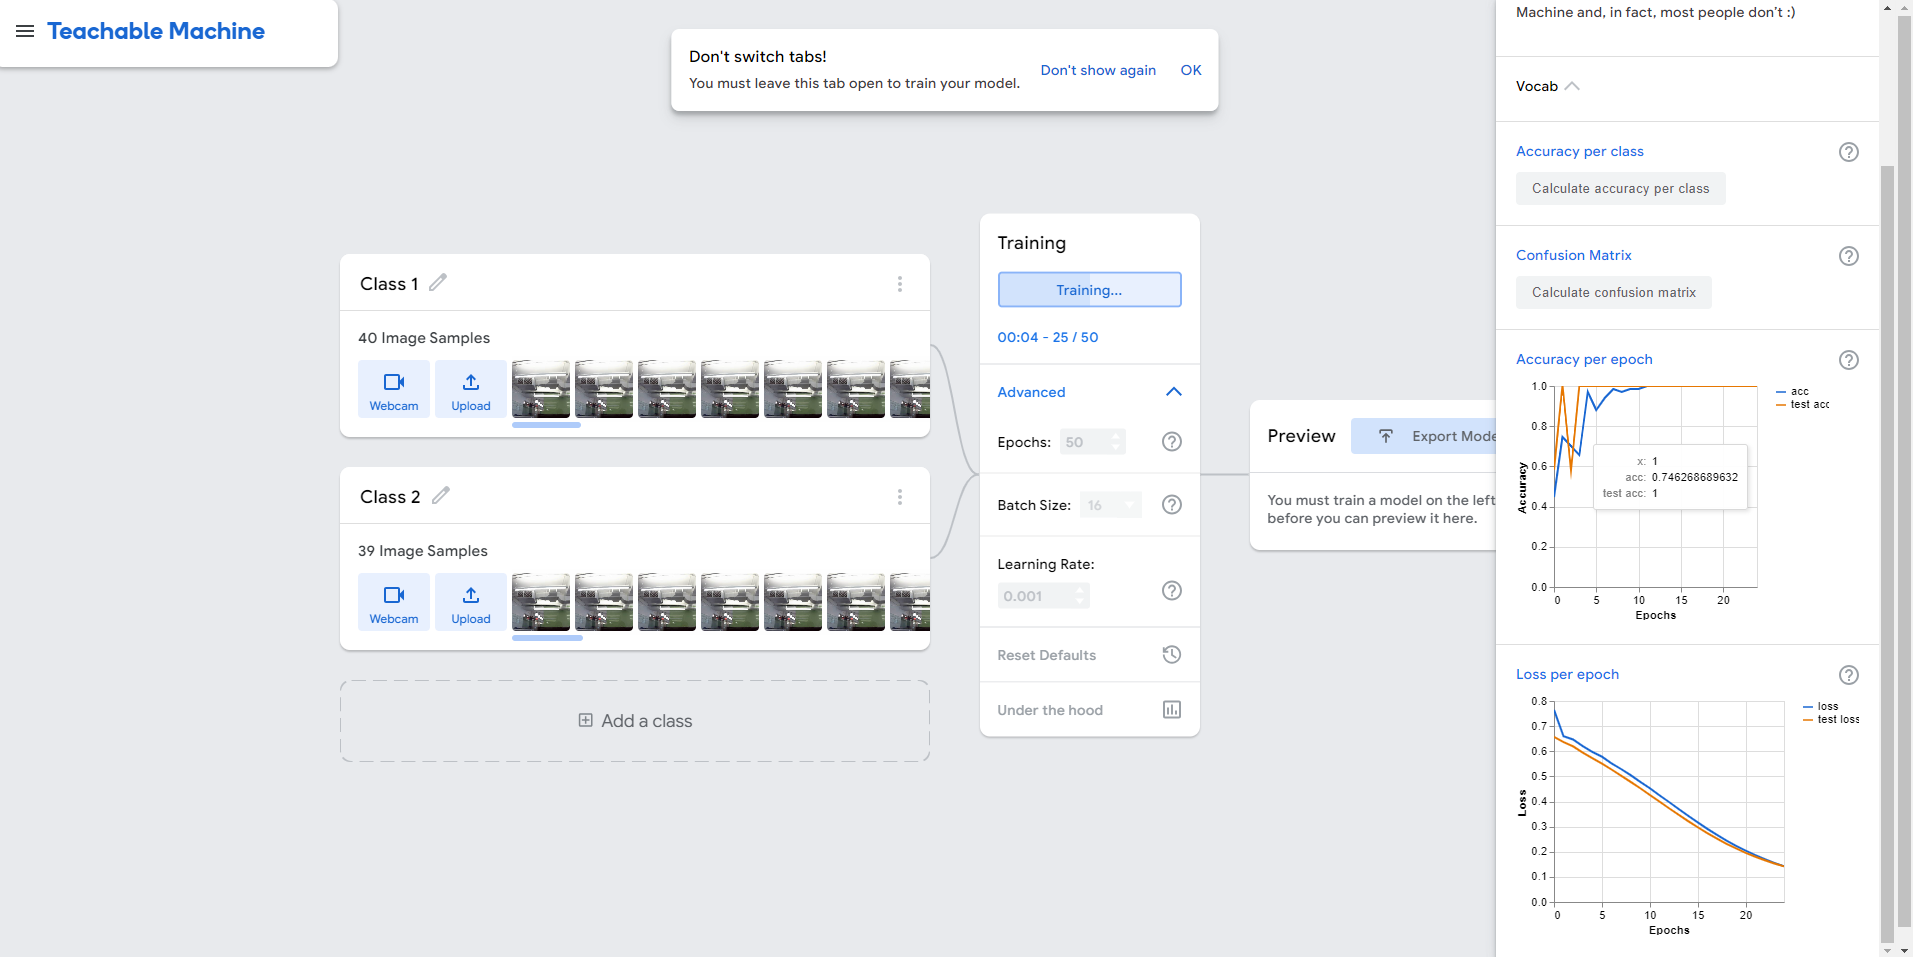
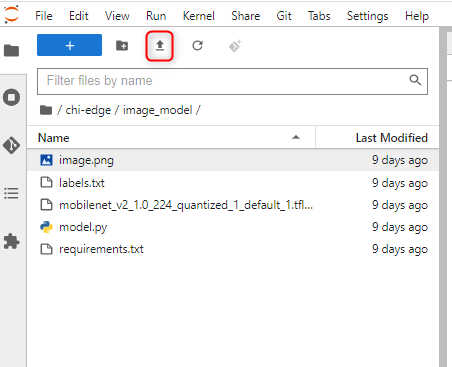

## Transfering files to the container

The next step is to transfer the image_model folder to the container. Below mentioned are all contained in the `image_model` directory:

-   Image classification model trained by teachable machine
-   a list of labels - this maps the integer values “predicted” by the model to human readable object names
-   a sample image (Which will be used for making prediction)
-   and Python code to load the model and make a prediction on the image

We can upload them to the container using the `container.upload` function, and specify the source directory (in the Jupyter environment) and destination directory (on the container).

In [ ]:
container.execute(my_container.uuid, 'mkdir -p /root/image_model')
container.upload(my_container.uuid, "./image_model", "/root/image_model")

## Use the image classification model by Teachable machine to do inference

First, we need to install a couple of Python libraries in the container:

-   `tflite` is a library specifically designed for machine learning inference on edge devices.
-   `Pillow` is used for image processing.

In [ ]:
container.execute(my_container.uuid, 'pip install tflite-runtime Pillow')

Then, we can run the image classification model! We will ask it to make a prediction for the following image:

In [ ]:
from IPython.display import Image
Image('image_model/parrot.jpg') 

To make the prediction we need to pass the model_file name, Image_name which we want to do prediction and the name of the file that contains the labels of the model

In [ ]:
result = container.execute(my_container.uuid, 'python /root/image_model/model.py model_path image_name labelfile_name')
print(result['output'])

Make a note of the time it took to generate the prediction - would this inference time be acceptable for all applications?

## Delete the container

Finally, we should stop and delete our container so that others can create new containers using the same lease. To delete our container, we can run the following cell:

In [ ]:
container.destroy_container(my_container.uuid)

Also free up the IP that you we attached to the container, now that it is no longer in use:

In [ ]:
ip_details = chi.network.get_floating_ip(public_ip)
chi.neutron().delete_floatingip(ip_details["id"])